# Aug 17th, 2022 (Degree: 0 --> NaN; zscore)

**Motivation**:  <br>

In [1]:
# HIDE CODE


import os
import sys
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from figures.fighelper import *
from analysis.final import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

## Fig dir

In [2]:
nn = 512
perc = 15
fig_dir = 'Fig7_Degree'
fig_dir = pjoin(fig_base_dir, 'paper2.0', f'n{nn}-p{perc}', fig_dir)
os.makedirs(fig_dir, exist_ok=True)
print(fig_dir)

kws_fig = {
    'transparent': True,
    'bbox_inches': 'tight',
    'dpi': 300,
}

/home/hadi/Dropbox/git/jb-Ca-fMRI/figs/paper2.0/n512-p15/Fig7_Degree

## Prepare (512)

In [9]:
num_k = 7
mice = Mice(nn)
pal = prepare_palette()

## Degree

In [4]:
%%time

results = similiarity_results(
    mice=mice,
    perc=perc,
    num_k=num_k,
    merge_thres=0.444,
    n_resamples=None,
)
bt = BootStrap(**results['props_ca'])
list(results)

CPU times: user 14.5 s, sys: 13.2 s, total: 27.7 s
Wall time: 1min 12s


['bt_dict', 'props_bo', 'props_ca', 'pi_sorted', 'sim', 'sim_overall']

In [5]:
for mode, o in results['bt_dict'].items():
    o.run_deg = np.array(o.run_deg)
    o.run_deg[o.run_deg == 0] = np.nan

In [6]:
%%time

cut, se, bins, xs = cut4figs('deg', results['bt_dict'], bt.get_booter(int(1e5)))
len(xs), len(bins)

CPU times: user 6.9 s, sys: 0 ns, total: 6.9 s
Wall time: 6.9 s


(69, 70)

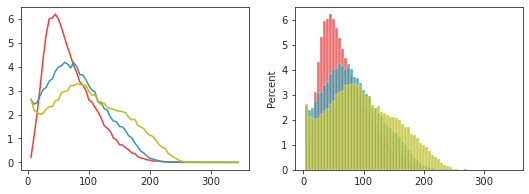

In [10]:
fig, axes = create_figure(1, 2, (9, 3))
for mode, o in results['bt_dict'].items():
    axes[0].plot(xs, avg(cut[mode], 1), color=pal[mode])
    sns.histplot(
        data=o.run_deg[np.isfinite(o.run_deg)],
        bins=bins,
        stat='percent',
        color=pal[mode],
        ax=axes[1],
    )

In [13]:
deg = {
    mode: avg(o.run_deg, 1) for
    mode, o in results['bt_dict'].items()
}

In [14]:
{k: (np.round(np.nanmin(v)), np.round(np.nanmax(v))) for k, v in deg.items()}

{
    'BOLD': (26.0, 118.0),
    'Ca$^{2\\!\\!+}_{slow}$': (17.0, 159.0),
    'Ca$^{2\\!\\!+}_{fast}$': (1.0, 198.0)
}

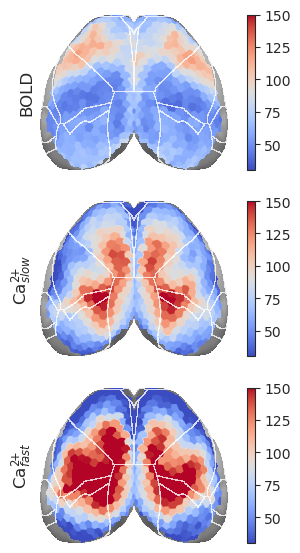

In [15]:
_ = bt.show(
    data=deg,
    figsize=(5, 7),
    vmin=30,
    vmax=150,
    add_disjoint=False,
    cmap='coolwarm',
    cbar=True,
)

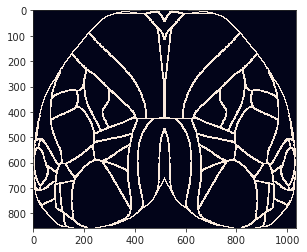

In [16]:
contour = bt.get_contour(0.2, False)
plt.imshow(contour);

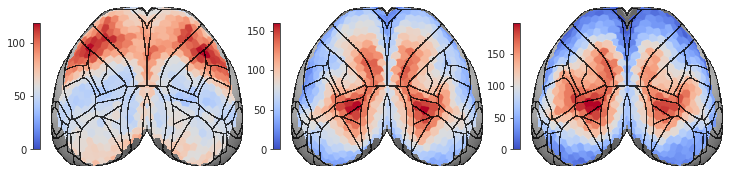

In [17]:
fig, axes = create_figure(1, 3, (10, 3), tight_layout=False, constrained_layout=True)
for ax, (mode, x) in zip(axes.flat, deg.items()):
    x[x == 0] = np.nan
    
    if mode == BOLD:
        vmin = 0
        nbins = 4
    elif mode == CAS:
        vmin = 0
        nbins = 6
    elif mode == CAF:
        vmin = 0
        nbins = 6
    else:
        raise NotImplementedError
    vmax = np.nanmax(x)
    
    ax, cbar = ctx2ax(
        x=x,
        ax=ax,
        base=bt,
        vmin=vmin,
        vmax=vmax,
        cmap='coolwarm',
        cbar_shrink=0.6,
        contour=contour,
        contour_cmap='Greys_r',
        cbar_tick_nbins=nbins,
        cbar_aspect=20,
    )
remove_ticks(axes)

# fig.savefig(pjoin(fig_dir, 'ctx.png'), **kws_fig)

plt.show()

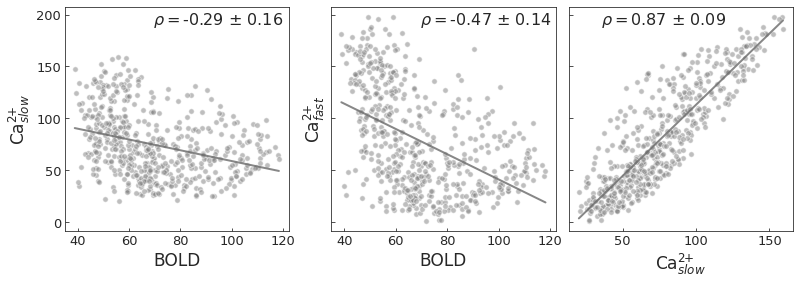

In [21]:
fig, _ = pairwise_lite(
    attr='deg',
    bt_dict=results['bt_dict'],
    good=git_good('deg', results['bt_dict']),
    n_resamples=int(1e3),
)
# fig.savefig(pjoin(fig_dir, 'pw.pdf'), **kws_fig)
# fig.savefig(pjoin(fig_dir, 'pw.png'), **kws_fig)

In [76]:
adj = {}

kwargs = {
    'task': 'rest',
    'band_bo': 0.01,
}
adj[BOLD] = collect_adjacencies(mice, 'bold-lite', **kwargs)[0]

kwargs = {
    'task': 'rest',
    'band_ca': (0.01, 0.50),
}
adj[CAS] = collect_adjacencies(mice, 'ca2', **kwargs)[0]

kwargs = {
    'task': 'rest',
    'band_ca': 0.50,
}
adj[CAF] = collect_adjacencies(mice, 'ca2', **kwargs)[0]

In [77]:
adj_bin = collections.defaultdict(list)
for mode, a_all in adj.items():
    for a in a_all:
        thresholds = calculate_threshold(a, perc / 100)
        _a = a.copy()
        _a[a <= thresholds.item()] = 0
        _a[a > thresholds.item()] = 1
        adj_bin[mode].append(np.expand_dims(_a, 0))
adj_bin = {k: np.concatenate(v) for k, v in adj_bin.items()}

In [50]:
partition = {}
for mode, o in results['bt_dict'].items():
    partition[mode] = o.get_disjoint_community()

In [159]:
kappa = {
    mode: np_nans(len(o.n2l)) for
    mode, o in results['bt_dict'].items()
}
for mode, pt in partition.items():
    a_all = []
    for a in adj_bin[mode]:
        deg = np.nansum(a, 0)
        a[deg == 0] = np.nan
        a[:, deg == 0] = np.nan
        a_all.append(np.expand_dims(a, 0))
    a_all = np.concatenate(a_all)
    for idx in range(1, num_k + 1):
        nodes = pt == idx
        ka = a_all[..., nodes][:, nodes, :]
        ka = bn.nansum(ka, -1)
        ka = bn.nanmean(ka, 0)
        ka = sp_stats.zscore(ka, axis=-1)
        kappa[mode][nodes] = ka

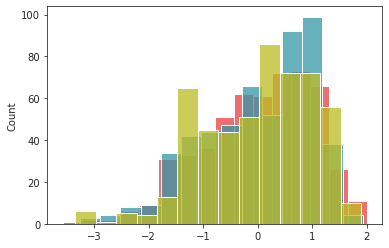

In [160]:
for mode, x in kappa.items():
    sns.histplot(x, color=pal[mode])

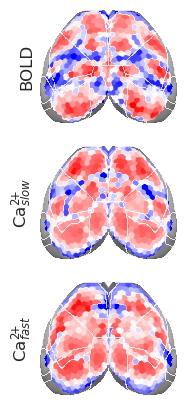

In [161]:
_ = bt.show(kappa, vmin=-2, vmax=2, cmap='bwr')

In [162]:
good = git_good('deg', results['bt_dict'])

In [163]:
sp_stats.pearsonr(kappa[BOLD][good], kappa[CAS][good])

(0.31337565477765456, 1.5334922915060908e-13)

In [164]:
sp_stats.pearsonr(kappa[BOLD][good], kappa[CAF][good])

(0.19436581641795106, 6.571178565421233e-06)

In [165]:
sp_stats.pearsonr(kappa[CAS][good], kappa[CAF][good])

(0.6440747144490699, 1.960452924797661e-63)

In [166]:
kappa = {
    mode: np_nans(len(o.n2l)) for
    mode, o in results['bt_dict'].items()
}
for mode, pt in partition.items():
    a_all = []
    for a in adj_bin[mode]:
        deg = np.nansum(a, 0)
        a[deg == 0] = np.nan
        a[:, deg == 0] = np.nan
        a_all.append(np.expand_dims(a, 0))
    a_all = np.concatenate(a_all)
    for idx in range(1, num_k + 1):
        nodes = pt == idx
        ka = a_all[..., nodes][:, nodes, :]
        ka = bn.nansum(ka, -1)
        ka = sp_stats.zscore(ka, axis=-1)
        ka = bn.nanmean(ka, 0)
        kappa[mode][nodes] = ka

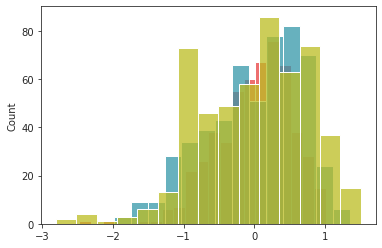

In [167]:
for mode, x in kappa.items():
    sns.histplot(x, color=pal[mode])

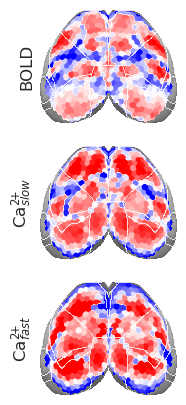

In [169]:
_ = bt.show(kappa, vmin=-1, vmax=1., cmap='bwr')

In [170]:
good = git_good('deg', results['bt_dict'])

In [171]:
sp_stats.pearsonr(kappa[BOLD][good], kappa[CAS][good])

(0.3108406321224707, 2.4552309170422297e-13)

In [172]:
sp_stats.pearsonr(kappa[BOLD][good], kappa[CAF][good])

(0.14029498321895084, 0.0012027105083906155)

In [173]:
sp_stats.pearsonr(kappa[CAS][good], kappa[CAF][good])

(0.6318358046220247, 2.089983418757324e-60)

In [92]:
for mode, pt in partition.items():
    a_all = adj_bin[mode]
    for a in a_all:
        bad = bn.nansum(a, -1) == 0
        a[bad] = np.nan
        a[:, bad] = np.nan
    for idx in range(1, num_k + 1):
        nodes = pt == idx
        kappa = a[..., nodes][:, nodes, :]
        kappa = bn.nansum(kappa, -1)

<AxesSubplot:ylabel='Count'>

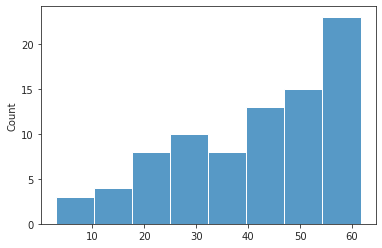

In [94]:
sns.histplot(bn.nanmean(kappa, 0))

<matplotlib.image.AxesImage object at 0x7fdffe3ccaf0>

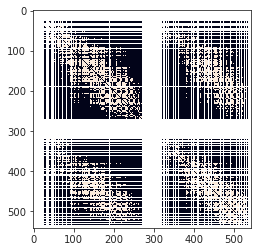

In [99]:
plt.imshow(a_all[-1])